In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/grinenko/anna/time_series/Forecasting.py'>

In [3]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [47]:
K = 5
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

In [48]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error as mae
mase = MeanAbsoluteScaledError(multioutput='raw_values')
mase_uni = MeanAbsoluteScaledError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='raw_values')
# mae = MeanAbsoluteError()


#if ‘raw_values’, returns a full set of errors in case of multioutput input. If ‘uniform_average’, errors of all outputs are averaged with uniform weight.

In [103]:
window_sizes_for_clustering = [1, 3, 5, 10]
Ns_clusters = [2, 5, 7, 9, 11]

In [50]:
Ns_clusters = [7]
window_sizes_for_clustering = [3]

In [80]:
dataset = df_np[:, :]
# dataset = np.concatenate((dataset[:, :8], dataset[:, 9:]), axis=1)
dataset.shape

(408096, 67)

In [81]:
from collections import defaultdict


In [104]:
maes = defaultdict(lambda: [])
mases = defaultdict(lambda: [])
mapes = defaultdict(lambda: [])
answers = {}
bad_values = np.zeros(dataset.shape[1])

dif=False

for window_size in window_sizes_for_clustering:
    for N_clusters in Ns_clusters:
        dataset_windows, dataset_y = Forecasting.create_windows(dataset, window_size=window_size)
        clusters_labels = Clustering.KMeans_for_windows(dataset_windows, W=window_size, N_clusters=N_clusters, max_iter=50)
        print(f"{clusters_labels.shape=}")
        datasets_clusters = Clustering.flatten_from_interceting_windows(dataset_windows, clusters_labels, W=window_size, \
                N_clusters=N_clusters)
        # list of list of ndarrays [N_i, Q], dataset_clusters[cluster_num][i] - i-th part of dataset for cluster_num

        print(f"{N_clusters=}, {len(datasets_clusters)}, {len(datasets_clusters[0])}, {datasets_clusters[0][0].shape}")
        ###window_size for model
        errors = [1] * N_clusters
        for cluster_num in range(N_clusters):
            sc = Forecasting.MyStandardScaler(dif=dif)
            #datasets_clusters[cluster_num] - list of [N_i, Q] ndarrays
            sc.fit(datasets_clusters[cluster_num])
            prepared_data = sc.transform(datasets_clusters[cluster_num])
            data_X, data_y = Forecasting.create_windows(prepared_data, window_size=10)
            #data_X - list of [N_i-W, W, Q] ndarrays
            train_X, train_y, valid_X, valid_y, test_X, test_y, ind = Forecasting.split_to_train_test(data_X, data_y, part_of_test=0.2, part_of_valid=0.2)
            #ndarrays [N_i, W, Q] or [N_i, Q]
            ind = np.array(ind) + window_size
            print(f"Before prediction: {train_X.shape=}, {train_y.shape=}, {test_X.shape=}, {test_y.shape=}")
            try:
                assert(len(test_X.shape) == 3 and test_X.shape[0] > 0)
                assert(len(valid_X.shape) == 3 and valid_X.shape[0] > 0)
                assert(len(train_X.shape) == 3 and train_X.shape[0] > 0)
            except AssertionError:
                print(f"FAIL - {test_X.shape=}, {valid_X.shape=}, {train_X.shape=}")
                errors[cluster_num] = np.Inf
                continue
            model, history = Forecasting.learn(train_X, train_y, valid_X=valid_X, valid_y=valid_y)
            predicted = model.predict(test_X)
            predicted_original = sc.inverse_transform(predicted)[0]
            #inverse_trasform returns list of ndarrays 
            if dif:
                #константа при дифференцировании
                predicted_original = sc.add_first_element(predicted_original, ind)[0]
            print(f"{predicted_original.shape=}, {test_y.shape=}")

            #calc all metrics
            cur_mae = mae(test_y, predicted_original, multioutput='raw_values')
#             error_out = mase(test_y, predicted_original, y_train=test_y)
#             error_in = mase(test_y, predicted_original, y_train=train_y)
            # cur_mase = mase(test_y, predicted_original, y_train=test_y)
            cur_mape = mape(test_y, predicted_original)
            cur_mase = Forecasting.my_mase(test_y, predicted_original, multioutput='raw_values')
            maes[(window_size, N_clusters)].append(cur_mae)
#             mases[(window_size, N_clusters)].append((error_in, error_out))
            mapes[(window_size, N_clusters)].append(cur_mape)
#             errors[cluster_num] = mase_uni(test_y, predicted_original, y_train=test_y)
            errors[cluster_num] = Forecasting.my_mase(test_y, predicted_original, multioutput='uniform_average')
            tmp_bad = cur_mase > np.percentile(cur_mase, 95)
            bad_values += tmp_bad
            cur_mase[tmp_bad] = -1
            #show all metrics
            plt.figure(figsize=(12, 10))
            plt.suptitle(f"K={N_clusters}, W={window_size}, C={cluster_num}")
            plt.subplot(2, 2, 1)
            plt.plot(cur_mae, color="green", label="library")
#             plt.plot(Forecasting.my_mae(test_y, predicted_original, multioutput='raw_values'), color="red", label="custom")
            plt.title("MAE")
            plt.legend()

            plt.subplot(2, 2, 2)
#             plt.plot(error_in, label="library, in")
#             plt.plot(error_out, label="library, out")
            plt.plot(cur_mase, label="custom, out")
            plt.title("MASE")
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(cur_mape)
            plt.title("MAPE")
            plt.legend()

            plt.savefig(f"plots/Dataset2/K={N_clusters}  W={window_size} C={cluster_num}.png")
#             plt.show()
            plt.clf()
            # print(f"{cur_mae=}, {cur_mase=}, {cur_mape=}")
            # my_mase = mase()
            print(f"MASE in_sample = {error_in}, MASE out_sample = {error_out}")
            print(f"average MASE = {errors[cluster_num]}, my average MASE = {Forecasting.my_mase(test_y, predicted_original, multioutput='uniform_average')}")
            print(f"Cluster {cluster_num}, {errors[cluster_num]}")
        answers[(window_size, N_clusters)] = errors
        plt.figure(figsize=(12, 10))
        plt.suptitle(f"K={N_clusters}, W={window_size}")
        plt.subplot(2, 2, 1)

        plt.bar(np.arange(N_clusters), [np.sum(clusters_labels == i) for i in range(N_clusters)], color='blue')
        plt.title("Размеры кластеров")
        plt.subplot(2, 2, 2)
        plt.bar(np.arange(N_clusters), [len(datasets_clusters[i]) for i in range(N_clusters)], color="green")
        plt.title("Количество непрерывных отрезков")
        plt.subplot(2, 2, 3)
        plt.bar(np.arange(N_clusters), errors, color="red")
        plt.title("MASE на тесте каждого из кластеров")
        plt.subplot(2, 2, 4)
        plt.axis('tight')
        plt.axis('off')
        plt.table(cellText= [[f"{x:.2f}"] for x in errors],
                      rowLabels=list(range(N_clusters)),
                      loc='center')
#         plt.show()
        plt.savefig(f"plots/Dataset2/method1: {N_clusters=}  W={window_size}.png")
        #         plt.show()
        plt.clf()
        

clusters_labels.shape=(408095,)
N_clusters=2, 2, 21, (24, 67)
Before prediction: train_X.shape=(8, 10, 67), train_y.shape=(8, 67), test_X.shape=(3, 10, 67), test_y.shape=(3, 67)
Epoch 1/40
1/1 [==============================] - 0s 95ms/step - loss: 2.5459 - val_loss: 2.5625
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 2.5408 - val_loss: 2.5571
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 2.5359 - val_loss: 2.5516
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 2.5310 - val_loss: 2.5459
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 2.5263 - val_loss: 2.5402
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 2.5217 - val_loss: 2.5346
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 2.5173 - val_loss: 2.5291
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 2.5130 - val_loss: 2.5237
Epoch 9/40
1/1 [==============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(6120, 67), test_y.shape=(6120, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.3939

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(647, 67), test_y.shape=(647, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.393927

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(740, 67), test_y.shape=(740, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.393927

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(32, 67), test_y.shape=(32, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(647, 67), test_y.shape=(647, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.393927

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(26, 67), test_y.shape=(26, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

/tmp/ipykernel_423049/1036013534.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(28, 67), test_y.shape=(28, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(32, 67), test_y.shape=(32, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(26, 67), test_y.shape=(26, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(647, 67), test_y.shape=(647, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.393927

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(6120, 67), test_y.shape=(6120, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.3939

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(27, 67), test_y.shape=(27, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(1985, 67), test_y.shape=(1985, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.3939

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(40, 67), test_y.shape=(40, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(1985, 67), test_y.shape=(1985, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.3939

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(647, 67), test_y.shape=(647, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.393927

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(6121, 67), test_y.shape=(6121, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.3939

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(28, 67), test_y.shape=(28, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(30, 67), test_y.shape=(30, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(648, 67), test_y.shape=(648, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.393927

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(30, 67), test_y.shape=(30, 67)
MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MASE in_sample = [2.94477266e+17 2.44723269e+17 2.34084995e+16 4.42348725e+17
 4.51024016e+04 5.60659422e+04 1.31745323e+05 5.08796664e+04
 1.95394004e-01 7.60255899e+01 2.03975436e+03 7.33535702e+03
 5.69343080e+03 8.78201885e+03 0.00000000e+00 2.42473495e+04
 2.81851185e+04 4.85350839e+04 2.39611854e+02 1.43533604e+05
 5.09141883e+03 3.52736586e+02 5.73305552e+03 4.44261940e+02
 7.61770148e+03 3.53377675e+02 6.96568799e+03 4.45270524e+04
 1.20523353e+16 2.57916668e+04 2.05952330e+02 4.46476308e+16
 1.53125790e+06 4.87301062e+16 1.30594357e+06 4.61054461e+16
 1.48604913e+06 4.47131264e+16 1.53598891e+06 2.22982986e+15
 4.70171907e+03 5.50548106e+03 8.62186551e+03 8.44892973e+03
 6.18328585e+03 3.86890568e+03 2.59101186e+03 6.81091475e+03
 1.05153019e+04 1.73460030e+05 3.75901838e+03 1.50532807e+05
 5.66569604e+03 1.81859382e+04 1.72379575e+05 1.83564144e+05
 5.78942275e+03 4.58009869e+03 8.81205790e+02 2.90168721e+17
 3.39392720e+15 5.41738879e+15 2.48182942e+15 1.18048089e+16
 1.0370

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

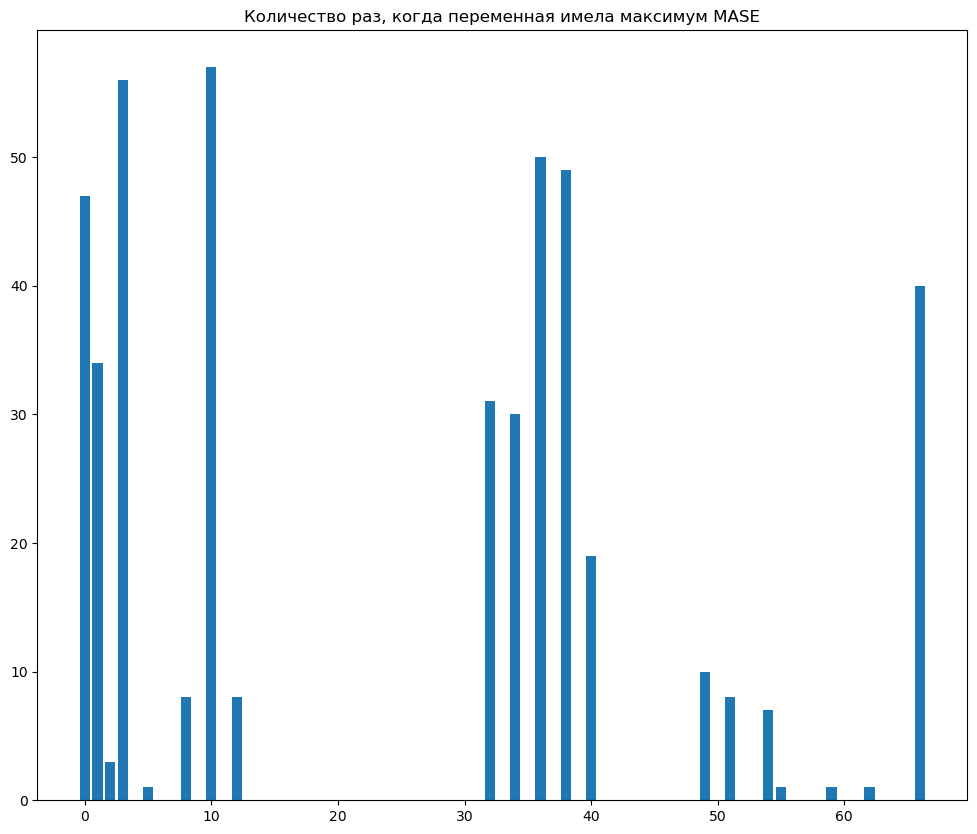

In [113]:
plt.figure(figsize=(12,10))
plt.bar(np.arange(bad_values.shape[0]), bad_values)
plt.title("Количество раз, когда переменная имела максимум MASE")
plt.savefig(f"plots/Dataset2/bad_values.png")
plt.show()

In [114]:
for key, val in maes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 10)}")

(1, 2)
     (array([ 2,  4,  7,  8, 11, 14, 18, 21, 23, 25, 28, 30, 33, 37, 39, 43, 60,
       61, 62, 63, 65]),)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
(1, 5)
     (array([ 2,  4,  9, 14, 18, 30, 39, 60, 61, 62, 63]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4,  8,  9, 11, 14, 18, 21, 22, 23, 24, 25, 26, 28, 30, 31, 33,
       39, 48, 50, 53, 60, 61, 62, 63, 65]),)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
(1, 7)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4, 12, 14, 18, 28, 30, 60, 61, 62]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62]),)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4,  8, 11, 14, 18, 20, 21, 22, 23, 25, 26, 28, 30, 33, 37, 39,
       41, 43, 60, 61, 62, 63, 65]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62, 63]),)
(1, 9)
     (array([ 2,  4,  9, 14, 18, 30, 60, 61, 62]),)
     (array([ 2,  4, 14

In [115]:
for key, val in mases.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c[0] < 1)}, {np.where(val_c[1] < 1)}")

In [116]:
for key, val in mapes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 1)}")

(1, 2)
     (array([14, 18, 25, 30, 31, 33, 35, 37, 43]),)
     (array([14, 30]),)
(1, 5)
     (array([14, 18, 30]),)
     (array([14]),)
     (array([ 8, 14, 65]),)
     (array([14]),)
(1, 7)
     (array([14, 61]),)
     (array([14]),)
     (array([14, 18, 30, 60]),)
     (array([14]),)
     (array([14, 61, 62]),)
     (array([ 8, 11, 14]),)
     (array([14]),)
(1, 9)
     (array([14]),)
     (array([14]),)
     (array([14]),)
     (array([14, 18, 30]),)
     (array([ 4,  8, 14, 18, 30]),)
     (array([14, 61]),)
     (array([14, 60, 61]),)
(1, 11)
     (array([14]),)
     (array([14, 18, 30]),)
     (array([14]),)
     (array([14, 60, 61]),)
     (array([ 8, 14, 18, 30]),)
     (array([ 8, 14, 65]),)
     (array([14]),)
(3, 2)
     (array([ 4, 14, 18, 30, 31, 33, 35, 37, 42, 62]),)
     (array([14, 30]),)
(3, 5)
     (array([14]),)
     (array([14, 18, 30]),)
     (array([ 8, 14]),)
     (array([14]),)
     (array([14]),)
(3, 7)
     (array([14, 18, 30]),)
     (array([ 8, 14]),)
   